# Study notebook – Processament del dataset i figures

Aquest notebook:
1) Localitza automàticament la **root** del repositori `potato-dry-matter-optics-ml` i defineix rutes.
2) Carrega un dataset raw de dades mesurades al laboratori, es queda només amb unes columnes clau i elimina files amb NaN.
3) Calcula:
   - `MS_experimental` (mitjana de `MS1` i `Ms2`)
   - `canal_NIR` (amb `nir_scalation(canal_NIR_raw, ref_NIR)`)
   - Mitjanes i desviacions RGB a partir del **crop** de la patata i el filtratge de colors extrems
4) Desa el dataset processat i genera figures d'estudi.

> ⚠️ Nota: `potato_pixels_rgb_img` fa servir Roboflow. Si no tens `ROBOFLOW_API_KEY` definit, la segmentació no funcionarà.


In [12]:
# Imports bàsics
import os
import sys
import re
import shutil
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm


In [23]:
# Definir rutes (ubicar-se a la root del projecte)
current_path = Path().resolve()
TARGET_ROOT_NAME = "potato-dry-matter-optics-ml"

while current_path.name != TARGET_ROOT_NAME and current_path.parent != current_path:
    current_path = current_path.parent

if current_path.name != TARGET_ROOT_NAME:
    raise RuntimeError(
        f"No s'ha trobat la carpeta '{TARGET_ROOT_NAME}' pujant des del directori actual: {Path().resolve()}"
    )

project_root = current_path
sys.path.append(str(project_root))

RUTA_DATASET = os.path.join(project_root, "data/input/raw/raw_dataset_test_1.csv")
RUTA_OUTPUT  = os.path.join(project_root, "data/input/processed/processed_dataset_test_1.csv")
IMAGES_ROOT = Path(project_root) / "data/input/raw/raw_images/test_1"

# Carpeta on desarem figures
FIG_DIR = Path(project_root) / "data/output/study/study_test_1"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Preparar output (és un FITXER .csv, no un directori)
output_parent = Path(RUTA_OUTPUT).parent
output_parent.mkdir(parents=True, exist_ok=True)
if os.path.exists(RUTA_OUTPUT):
    os.remove(RUTA_OUTPUT)

print(f"Project root: {project_root}")
print(f"Dataset input: {RUTA_DATASET}")
print(f"Dataset output: {RUTA_OUTPUT}")
print(f"Figures dir: {FIG_DIR}")
print(f"Imatges dir: {IMAGES_ROOT}")

# Comprovar Roboflow API key (necessària per potato_pixels_rgb_img)
if "ROBOFLOW_API_KEY" not in os.environ:
    print("⚠️ ROBOFLOW_API_KEY no està definida. La segmentació amb Roboflow fallarà.")
    print("   Pots definir-la així (només en aquesta sessió):")
    print("   os.environ['ROBOFLOW_API_KEY'] = 'LA_TEVA_CLAU'")


Project root: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml
Dataset input: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/input/raw/raw_dataset_test_1.csv
Dataset output: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/input/processed/processed_dataset_test_1.csv
Figures dir: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1
Imatges dir: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\input\raw\raw_images\test_1


In [14]:
# Carregar el dataset (detecta automàticament separador i decimals)
def _detect_sep(path: str) -> str:
    first = Path(path).read_text(encoding="utf-8", errors="replace").splitlines()[0]
    return ";" if first.count(";") >= first.count(",") else ","

def _to_float_series(s: pd.Series) -> pd.Series:
    # Converteix valors amb coma decimal i possibles tabs/espais a float
    def _clean_one(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float, np.number)):
            return float(x)
        x = str(x).strip().replace("\t", "").replace(" ", "")
        if x == "" or x.lower() in {"nan", "none"}:
            return np.nan
        # canvia coma decimal -> punt
        x = x.replace(",", ".")
        # Manté només caràcters numèrics vàlids (inclou signe i exponent)
        x = re.sub(r"[^0-9eE\+\-\.]", "", x)
        try:
            return float(x)
        except Exception:
            return np.nan
    return s.map(_clean_one).astype(float)

sep = _detect_sep(RUTA_DATASET)
print(f"Separador detectat: {sep!r}")

df = pd.read_csv(
    RUTA_DATASET,
    sep=sep,
    engine="python",
    na_values=["", "NaN", "nan", "None"],
    keep_default_na=True,
)

# Columnes que volem conservar i exigir sense NaN
keep_cols = [
    "id_mostra",
    "ruta_imatges",
    "lot",
    "M_aire(g)",
    "M_aigua(g)",
    "ge",
    "MS1",
    "Ms2",
    "h2",
    "densitat",
    "canal_NIR_raw",
    "ref_NIR",
    "y1_y2",
    "y1_y2_norm",
]

missing = [c for c in keep_cols if c not in df.columns]
if missing:
    raise KeyError(f"Falten columnes al CSV: {missing}\nColumnes disponibles: {list(df.columns)}")

# Ens quedem només amb aquestes
df = df[keep_cols].copy()

# Conversions numèriques (totes menys ruta_imatges i lot)
num_cols = [c for c in keep_cols if c not in ("id_mostra", "ruta_imatges", "lot")]
for c in num_cols:
    df[c] = _to_float_series(df[c])

# id_mostra a index (enter si es pot)
df["id_mostra"] = _to_float_series(df["id_mostra"])
df = df.dropna(subset=["id_mostra"])
df["id_mostra"] = df["id_mostra"].astype(int)
df = df.set_index("id_mostra")

# Netejar strings
df["ruta_imatges"] = df["ruta_imatges"].astype(str).str.strip()
df["lot"] = df["lot"].astype(str).str.strip()

# Drop de files amb algun NaN a qualsevol de les columnes clau
before = len(df)
df = df.dropna(subset=keep_cols[1:])  # totes excepte id_mostra (ara index)
after = len(df)
print(f"Files abans: {before} | després de drop NaNs: {after} | eliminades: {before-after}")

print("\n=== INFORMACIÓ DEL DATASET (després de neteja inicial) ===\n")
display(df.head())
df.info()


Separador detectat: ';'
Files abans: 35 | després de drop NaNs: 9 | eliminades: 26

=== INFORMACIÓ DEL DATASET (després de neteja inicial) ===



,ruta_imatges,lot,M_aire(g),M_aigua(g),ge,MS1,Ms2,h2,densitat,canal_NIR_raw,ref_NIR,y1_y2,y1_y2_norm
id_mostra,,,,,,,,,,,,,
2,p1_2.png,L1,201.0,13.5,1.072000,18.529128,18.522000,18.5,1.216827,16376.0,7349.0,1.161383,1.211100
9,p1_9.png,L1,77.0,6.9,1.098431,24.107087,24.098902,17.8,0.874027,57633.0,22479.0,1.035119,1.046172
10,p1_10.png,L1,156.0,11.0,1.075862,19.344179,19.336897,18.2,1.180504,48462.0,17479.0,1.063380,1.083851
11,p1_11.png,L1,75.0,6.0,1.086957,21.685552,21.677826,17.5,1.362120,58997.0,21951.0,1.056038,1.075324
12,p1_12.png,L1,102.0,8.4,1.089744,22.273735,22.265897,18.3,0.712493,643590.0,258850.0,1.184230,1.256611


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2 to 29
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ruta_imatges   9 non-null      object 
 1   lot            9 non-null      object 
 2   M_aire(g)      9 non-null      float64
 3   M_aigua(g)     9 non-null      float64
 4   ge             9 non-null      float64
 5   MS1            9 non-null      float64
 6   Ms2            9 non-null      float64
 7   h2             9 non-null      float64
 8   densitat       9 non-null      float64
 9   canal_NIR_raw  9 non-null      float64
 10  ref_NIR        9 non-null      float64
 11  y1_y2          9 non-null      float64
 12  y1_y2_norm     9 non-null      float64
dtypes: float64(11), object(2)
memory usage: 972.0+ bytes


In [ ]:
# Imports de funcions del projecte
# (assumim que existeixen a src/raw_image_treatment.py dins del repo)
try:
    from src.raw_image_treatment import nir_scalation, potato_pixels_rgb_img, potato_filter_extreme_colours
except Exception as e:
    raise ImportError(
        "No he pogut importar des de src.raw_image_treatment.\n"
        "Assegura't que estàs executant aquest notebook dins del repo i que existeix src/raw_image_treatment.py\n"
        f"Error original: {e}"
    )

# 1) MS_experimental: mitjana entre MS1 i Ms2
df["MS_experimental"] = df[["MS1", "Ms2"]].mean(axis=1)

# 2) canal_NIR: normalització/escala
df["canal_NIR"] = nir_scalation(df["canal_NIR_raw"].values, df["ref_NIR"].values)

# Paràmetres (pots ajustar-los si vols)
SEGMENT_MARGIN = 50       # marge d'erosió en potato_pixels_rgb_img
FILTER_MARGIN  = 50      # marge de tolerància per potato_filter_extreme_colours

def _rgb_mean_std_ignore_black(pil_img) -> tuple:
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim != 3 or arr.shape[2] != 3:
        raise ValueError(f"Imatge RGB esperada, però arr shape={arr.shape}")
    mask = np.any(arr != 0, axis=2)  # ignora píxels negres (0,0,0)
    if mask.sum() == 0:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    vals = arr[mask]  # (N,3)
    mean = vals.mean(axis=0)
    std  = vals.std(axis=0)
    return (*mean.tolist(), *std.tolist())

means_R, means_G, means_B = [], [], []
stds_R, stds_G, stds_B = [], [], []

failed = 0
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Procesant imatges (RGB)"):
    img_rel = str(row["ruta_imatges"]).strip()
    img_path = IMAGES_ROOT / img_rel

    if not img_path.exists():
        failed += 1
        means_R.append(np.nan); means_G.append(np.nan); means_B.append(np.nan)
        stds_R.append(np.nan);  stds_G.append(np.nan);  stds_B.append(np.nan)
        continue

    cropped_img, _vis = potato_pixels_rgb_img(img_path, margin=SEGMENT_MARGIN)

    if cropped_img is None:
        failed += 1
        means_R.append(np.nan); means_G.append(np.nan); means_B.append(np.nan)
        stds_R.append(np.nan);  stds_G.append(np.nan);  stds_B.append(np.nan)
        continue

    filt_out = potato_filter_extreme_colours(cropped_img, margin=FILTER_MARGIN, ignore_black=True)

    # Compatibilitat: hi ha versions que retornen només la imatge, i altres (img, median_color)
    if isinstance(filt_out, tuple):
        filtered_img = filt_out[0]
    else:
        filtered_img = filt_out

    try:
        mR, mG, mB, sR, sG, sB = _rgb_mean_std_ignore_black(filtered_img)
    except Exception:
        failed += 1
        mR = mG = mB = sR = sG = sB = np.nan

    means_R.append(mR); means_G.append(mG); means_B.append(mB)
    stds_R.append(sR);  stds_G.append(sG);  stds_B.append(sB)

df["color_promig_R"] = means_R
df["color_promig_G"] = means_G
df["color_promig_B"] = means_B
df["desviació_R"] = stds_R
df["desviació_G"] = stds_G
df["desviació_B"] = stds_B

print(f"Files amb fallada (imatge no trobada / segmentació / càlcul): {failed}")

# Si vols assegurar-te que no queden NaNs en les noves features (recomanat per plots):
before2 = len(df)
df = df.dropna(subset=[
    "MS_experimental", "canal_NIR",
    "color_promig_R", "color_promig_G", "color_promig_B",
    "desviació_R", "desviació_G", "desviació_B",
])
after2 = len(df)
print(f"Drop NaNs extra (per features noves): {before2} -> {after2} (eliminades {before2-after2})")

display(df.head())


Procesant imatges (RGB): 100%|██████████| 9/9 [00:43<00:00,  4.79s/it]

Files amb fallada (imatge no trobada / segmentació / càlcul): 0
Drop NaNs extra (per features noves): 9 -> 9 (eliminades 0)


,ruta_imatges,lot,M_aire(g),M_aigua(g),ge,MS1,Ms2,h2,densitat,canal_NIR_raw,...,y1_y2,y1_y2_norm,MS_experimental,canal_NIR,color_promig_R,color_promig_G,color_promig_B,desviació_R,desviació_G,desviació_B
id_mostra,,,,,,,,,,,,,,,,,,,,,
2,p1_2.png,L1,201.0,13.5,1.072000,18.529128,18.522000,18.5,1.216827,16376.0,...,1.161383,1.211100,18.525564,2.228330,115.323373,85.586912,45.058336,29.044846,23.392175,14.589484
9,p1_9.png,L1,77.0,6.9,1.098431,24.107087,24.098902,17.8,0.874027,57633.0,...,1.035119,1.046172,24.102994,2.563860,119.784314,86.690106,47.603173,26.658292,20.979047,13.650236
10,p1_10.png,L1,156.0,11.0,1.075862,19.344179,19.336897,18.2,1.180504,48462.0,...,1.063380,1.083851,19.340538,2.772584,106.496365,80.429256,44.089925,26.336236,21.665844,14.311218
11,p1_11.png,L1,75.0,6.0,1.086957,21.685552,21.677826,17.5,1.362120,58997.0,...,1.056038,1.075324,21.681689,2.687668,106.499965,77.257010,42.522598,26.590493,21.024461,13.406674
12,p1_12.png,L1,102.0,8.4,1.089744,22.273735,22.265897,18.3,0.712493,643590.0,...,1.184230,1.256611,22.269816,2.486343,115.498354,82.875144,44.143710,25.883845,20.312658,12.792647


In [16]:
# Eliminar columnes que ja no volem
drop_cols = ["M_aire(g)", "M_aigua(g)", "ge", "MS1", "Ms2", "h2", "canal_NIR_raw", "ref_NIR"]
df_final = df.drop(columns=drop_cols, errors="ignore").copy()

# Guardar
df_final.to_csv(RUTA_OUTPUT, index=True)
print(f"✅ Dataset processat guardat a: {RUTA_OUTPUT}")

display(df_final.head())
df_final.info()


✅ Dataset processat guardat a: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data/input/processed/processed_dataset_test_1.csv


,ruta_imatges,lot,densitat,y1_y2,y1_y2_norm,MS_experimental,canal_NIR,color_promig_R,color_promig_G,color_promig_B,desviació_R,desviació_G,desviació_B
id_mostra,,,,,,,,,,,,,
2,p1_2.png,L1,1.216827,1.161383,1.211100,18.525564,2.228330,115.323373,85.586912,45.058336,29.044846,23.392175,14.589484
9,p1_9.png,L1,0.874027,1.035119,1.046172,24.102994,2.563860,119.784314,86.690106,47.603173,26.658292,20.979047,13.650236
10,p1_10.png,L1,1.180504,1.063380,1.083851,19.340538,2.772584,106.496365,80.429256,44.089925,26.336236,21.665844,14.311218
11,p1_11.png,L1,1.362120,1.056038,1.075324,21.681689,2.687668,106.499965,77.257010,42.522598,26.590493,21.024461,13.406674
12,p1_12.png,L1,0.712493,1.184230,1.256611,22.269816,2.486343,115.498354,82.875144,44.143710,25.883845,20.312658,12.792647


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2 to 29
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ruta_imatges     9 non-null      object 
 1   lot              9 non-null      object 
 2   densitat         9 non-null      float64
 3   y1_y2            9 non-null      float64
 4   y1_y2_norm       9 non-null      float64
 5   MS_experimental  9 non-null      float64
 6   canal_NIR        9 non-null      float32
 7   color_promig_R   9 non-null      float64
 8   color_promig_G   9 non-null      float64
 9   color_promig_B   9 non-null      float64
 10  desviació_R      9 non-null      float64
 11  desviació_G      9 non-null      float64
 12  desviació_B      9 non-null      float64
dtypes: float32(1), float64(10), object(2)
memory usage: 936.0+ bytes


Columnes al pairplot: ['densitat', 'y1_y2', 'y1_y2_norm', 'MS_experimental', 'canal_NIR', 'color_promig_R', 'color_promig_G', 'color_promig_B', 'desviació_R', 'desviació_G', 'desviació_B']
Files pel pairplot: 9


The figure layout has changed to tight


✅ Pairplot guardat a: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\pairplot_all_features.png


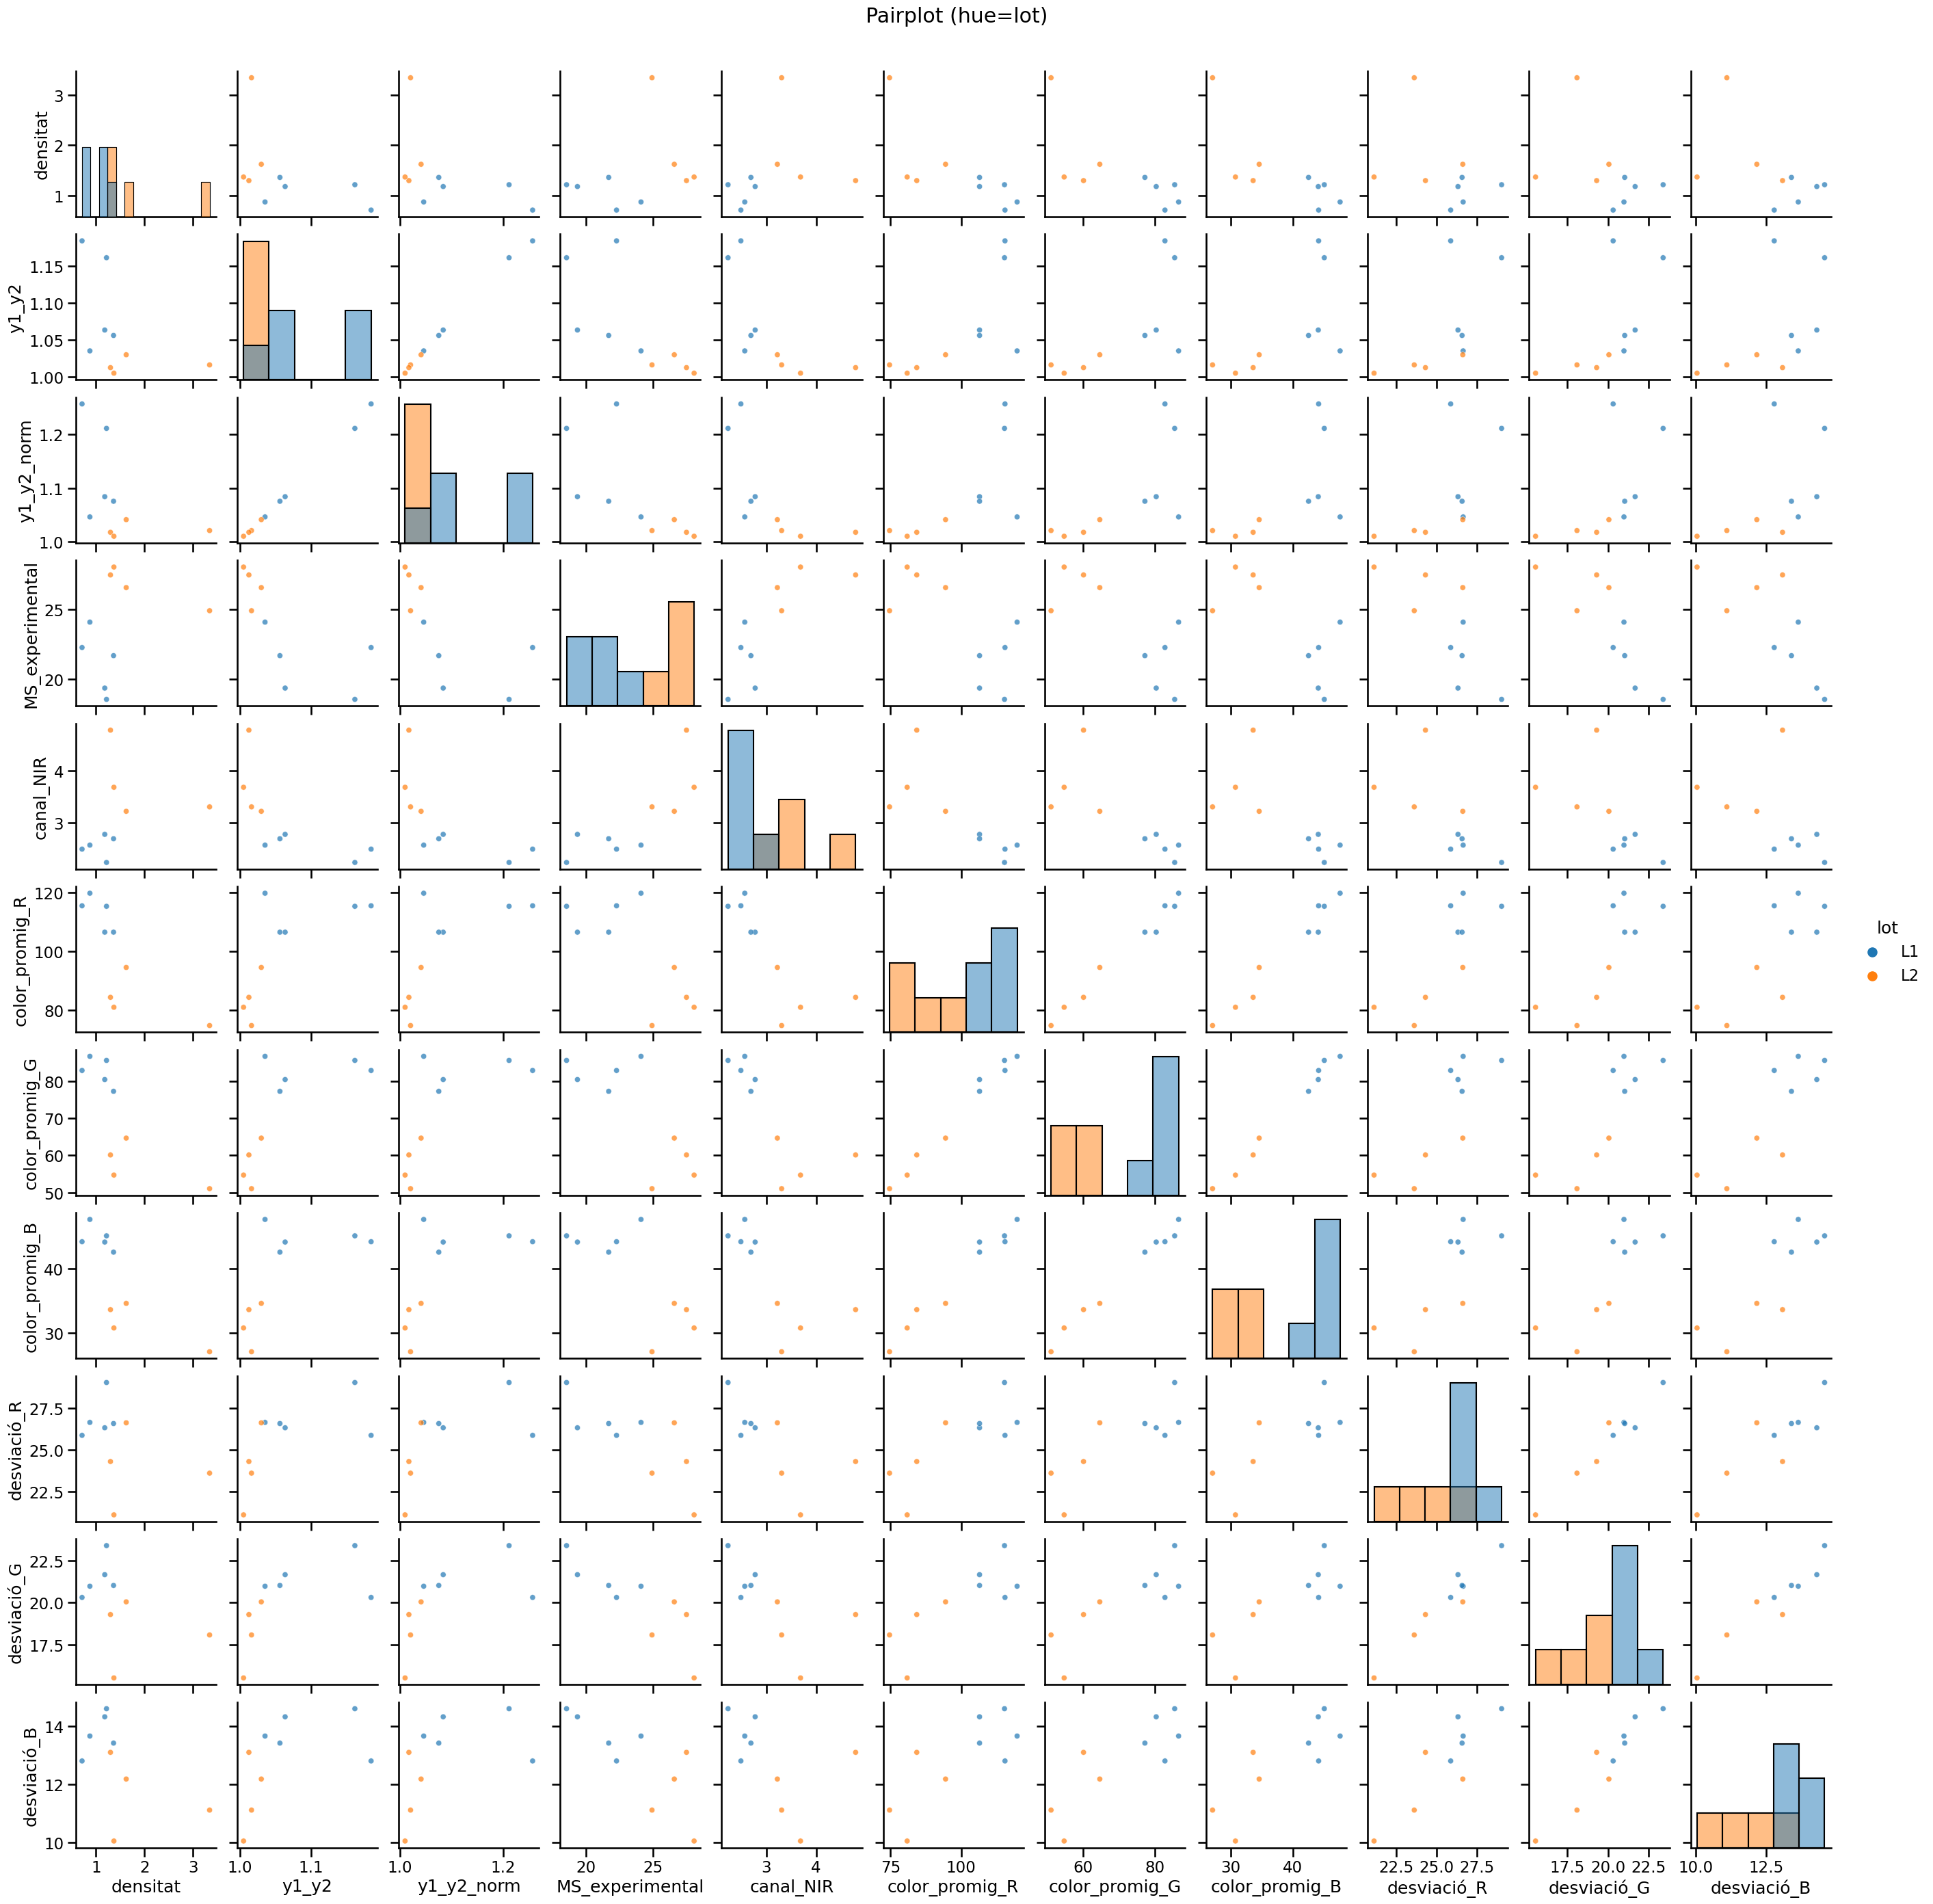

In [17]:
# Pairplot (totes les dades menys id_mostra i lot) amb color per lot
import numpy as np
import warnings

# --- 1) triar columnes a plotar (excloent lot i ruta_imattges) ----------
exclude = {"lot", "ruta_imattges", "ruta_imatges"}  # per si al df es diu diferent
vars_to_plot = [
    c for c in df_final.columns
    if c not in exclude and pd.api.types.is_numeric_dtype(df_final[c])
]

# --- 2) preparar dataframe per seaborn --------------------------------
pair_df = df_final[vars_to_plot + (["lot"] if "lot" in df_final.columns else [])].copy()

# Inf -> NaN (evita warnings i problemes)
pair_df = pair_df.replace([np.inf, -np.inf], np.nan)

# Drop NaNs només en el que realment es ploteja + hue
subset_cols = vars_to_plot + (["lot"] if "lot" in pair_df.columns else [])
pair_df = pair_df.dropna(subset=subset_cols)

print("Columnes al pairplot:", vars_to_plot)
print("Files pel pairplot:", len(pair_df))

sns.set_context("talk")

# --- 3) silenciar warnings molestos (opcional) ------------------------
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")
warnings.filterwarnings("ignore", message="When grouping with a length-1 list-like")

pair = sns.pairplot(
    data=pair_df,
    vars=vars_to_plot,
    hue="lot" if "lot" in pair_df.columns else None,
    corner=False,
    diag_kind="hist",
    plot_kws={"alpha": 0.7, "s": 35},
)

pair.fig.suptitle("Pairplot (hue=lot)", y=1.02)

pair_path = FIG_DIR / "pairplot_all_features.png"
pair.savefig(pair_path, dpi=200, bbox_inches="tight")
print(f"✅ Pairplot guardat a: {pair_path}")

plt.show()

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\ms_vs_colors_promig.png


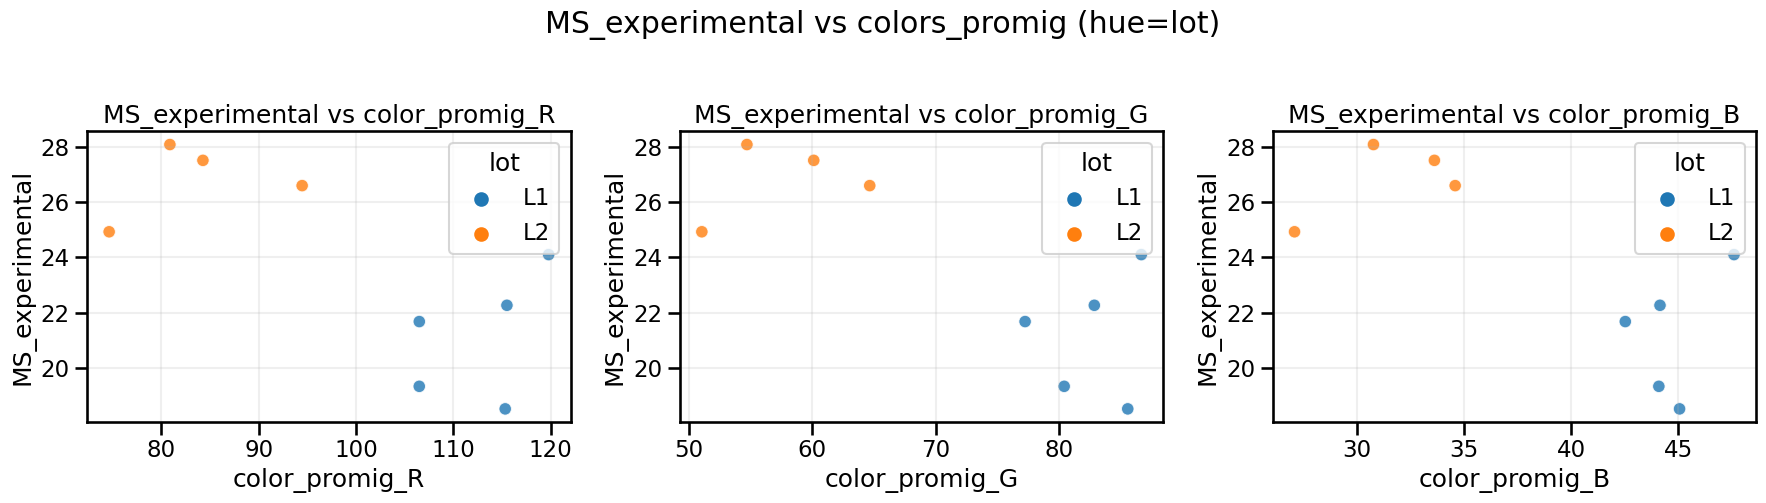

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\ms_vs_desviacions_rgb.png


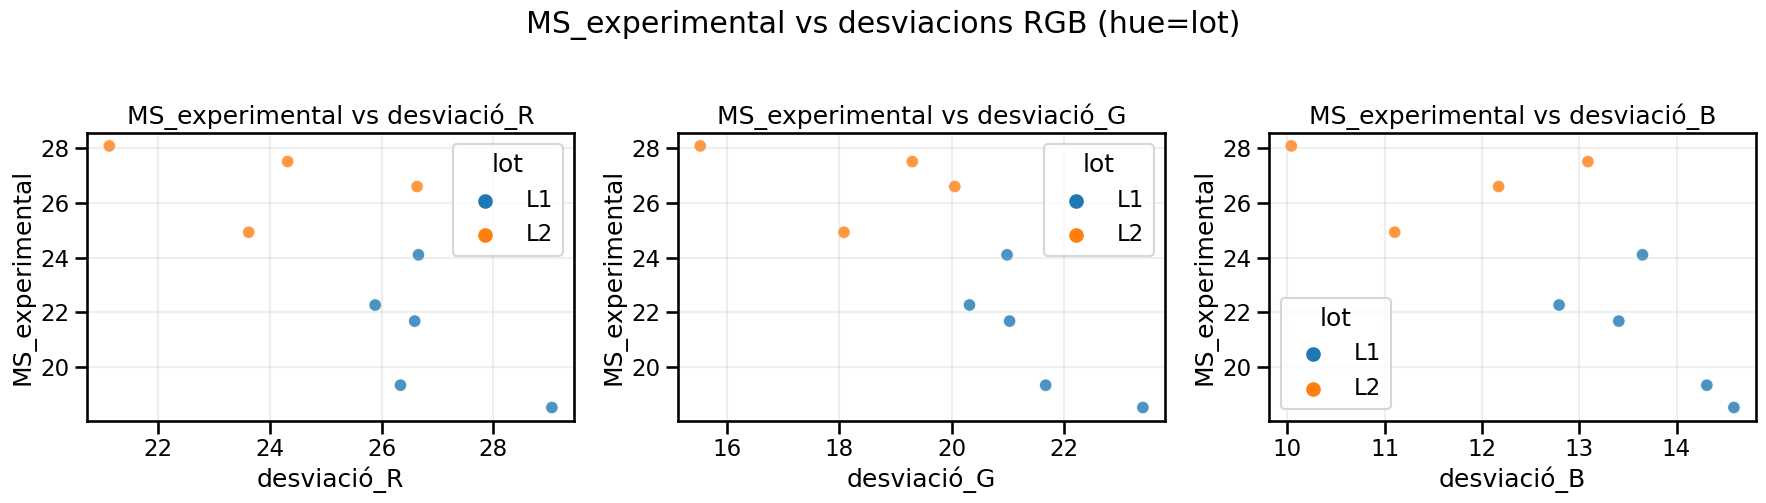

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\ms_vs_y1y2.png


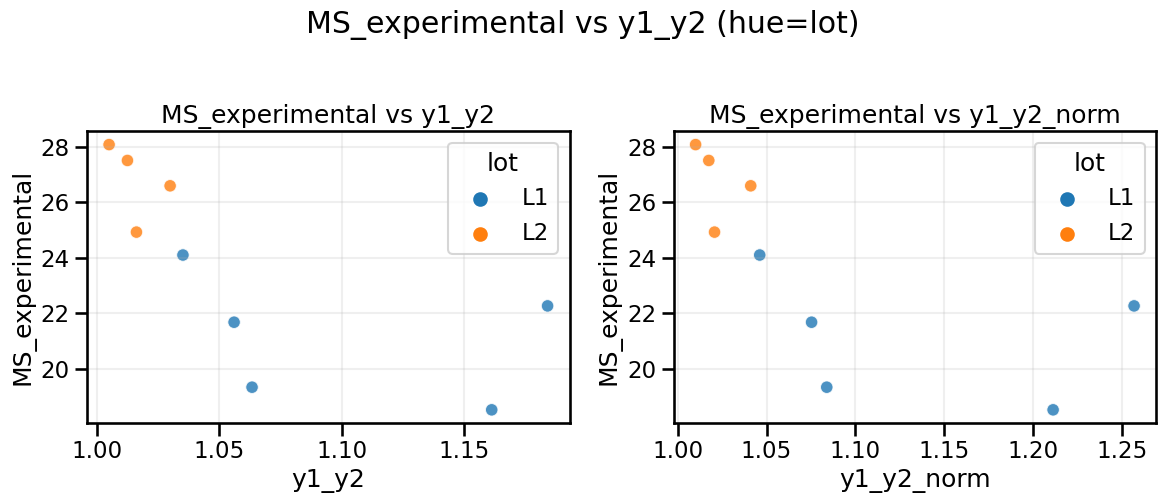

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\ms_vs_canal_NIR.png


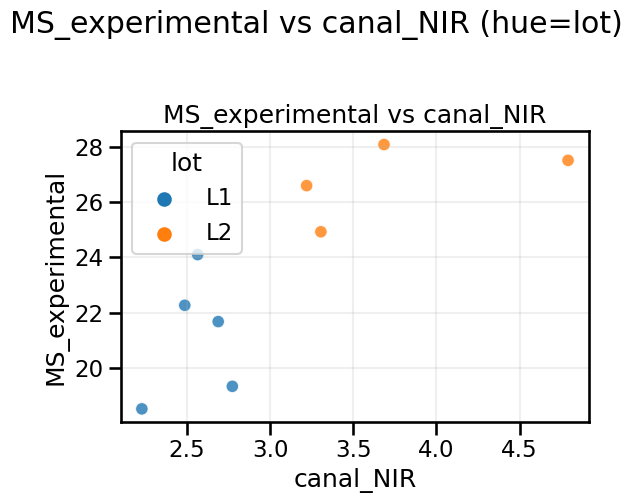

In [18]:
# Plots: MS_experimental (y) vs features (x), amb color per lot
sns.set_context("talk")

def _scatter_grid(y_col, x_cols, title, filename, ncols):
    nrows = int(np.ceil(len(x_cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows), squeeze=False)
    for i, x in enumerate(x_cols):
        r, c = divmod(i, ncols)
        ax = axes[r][c]
        sns.scatterplot(data=df_final.reset_index(), x=x, y=y_col, hue="lot", ax=ax, alpha=0.8)
        ax.set_title(f"{y_col} vs {x}")
        ax.grid(True, alpha=0.2)
    # Apagar axes buits
    for j in range(len(x_cols), nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r][c].axis("off")
    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    out = FIG_DIR / filename
    fig.savefig(out, dpi=200, bbox_inches="tight")
    print(f"✅ Figura guardada: {out}")
    plt.show()

# 3 en línia (colors promig)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["color_promig_R", "color_promig_G", "color_promig_B"],
    title="MS_experimental vs colors_promig (hue=lot)",
    filename="ms_vs_colors_promig.png",
    ncols=3,
)

# 3 en línia (desviacions)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["desviació_R", "desviació_G", "desviació_B"],
    title="MS_experimental vs desviacions RGB (hue=lot)",
    filename="ms_vs_desviacions_rgb.png",
    ncols=3,
)

# 2 en línia (y1_y2 i y1_y2_norm)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["y1_y2", "y1_y2_norm"],
    title="MS_experimental vs y1_y2 (hue=lot)",
    filename="ms_vs_y1y2.png",
    ncols=2,
)

# 1 plot (canal_NIR)
_scatter_grid(
    y_col="MS_experimental",
    x_cols=["canal_NIR"],
    title="MS_experimental vs canal_NIR (hue=lot)",
    filename="ms_vs_canal_NIR.png",
    ncols=1,
)


✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\densitat_vs_colors_promig.png


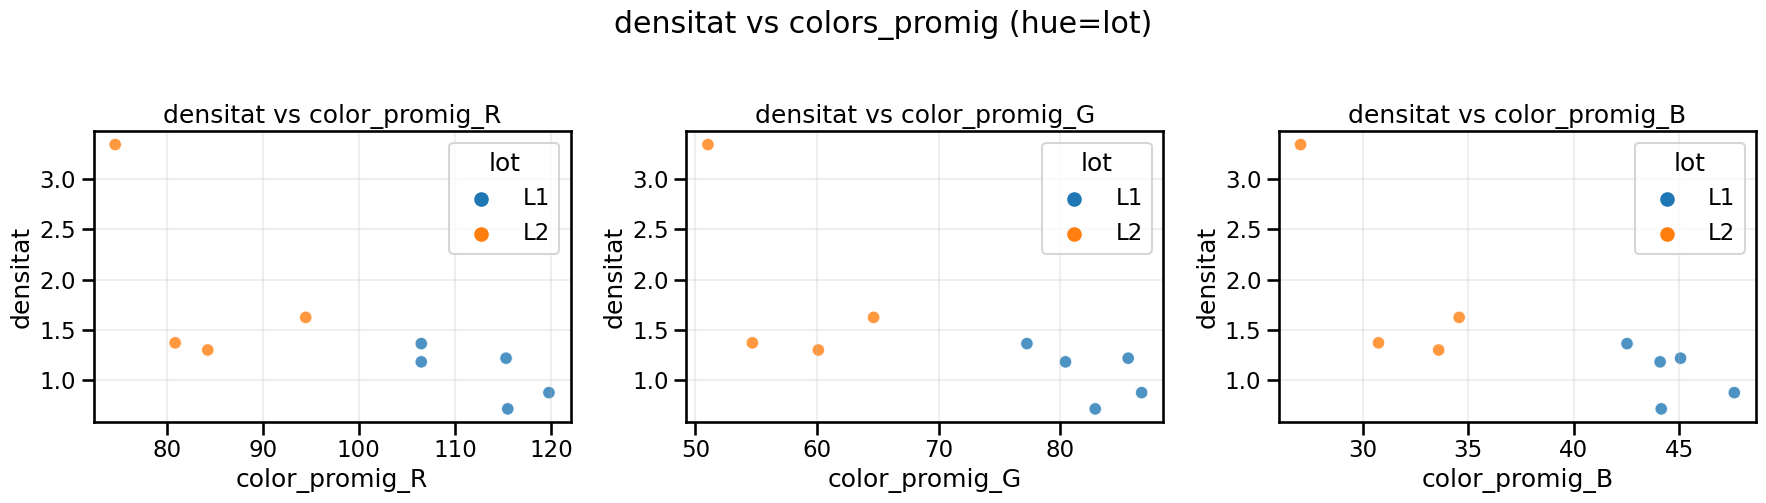

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\densitat_vs_desviacions_rgb.png


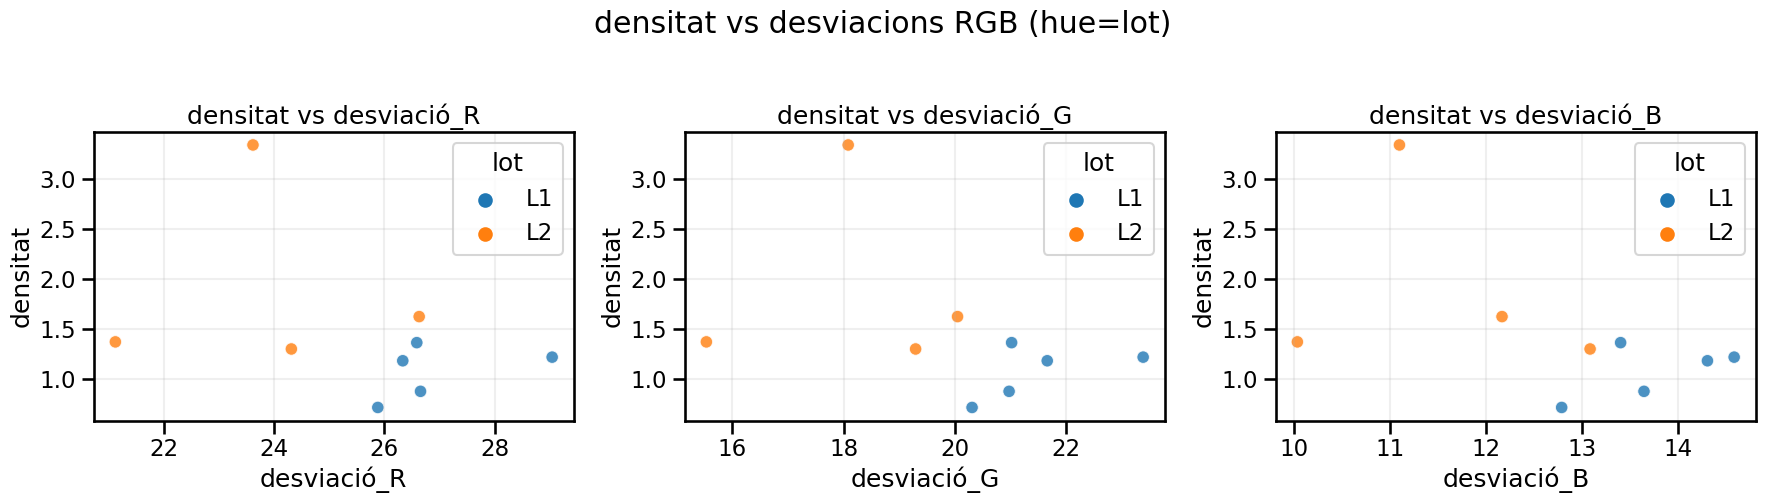

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\densitat_vs_y1y2.png


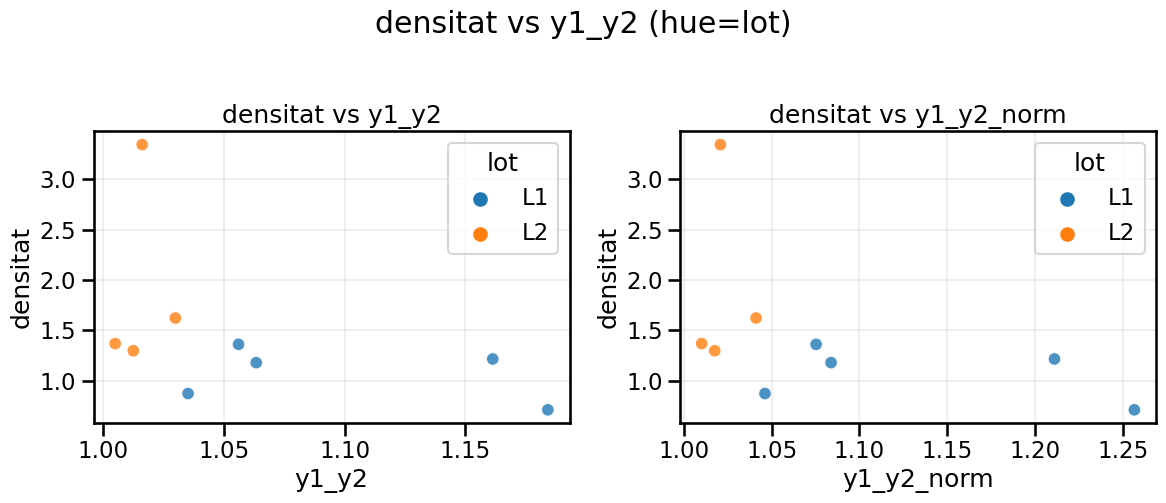

✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\densitat_vs_canal_NIR.png


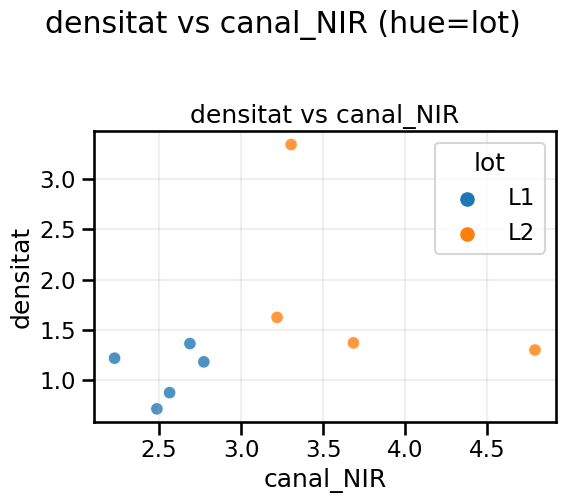

In [19]:
# Plots: densitat (y) vs features (x), amb color per lot
_scatter_grid(
    y_col="densitat",
    x_cols=["color_promig_R", "color_promig_G", "color_promig_B"],
    title="densitat vs colors_promig (hue=lot)",
    filename="densitat_vs_colors_promig.png",
    ncols=3,
)

_scatter_grid(
    y_col="densitat",
    x_cols=["desviació_R", "desviació_G", "desviació_B"],
    title="densitat vs desviacions RGB (hue=lot)",
    filename="densitat_vs_desviacions_rgb.png",
    ncols=3,
)

_scatter_grid(
    y_col="densitat",
    x_cols=["y1_y2", "y1_y2_norm"],
    title="densitat vs y1_y2 (hue=lot)",
    filename="densitat_vs_y1y2.png",
    ncols=2,
)

_scatter_grid(
    y_col="densitat",
    x_cols=["canal_NIR"],
    title="densitat vs canal_NIR (hue=lot)",
    filename="densitat_vs_canal_NIR.png",
    ncols=1,
)


✅ Figura guardada: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\output\study\study_test_1\ms_vs_densitat.png


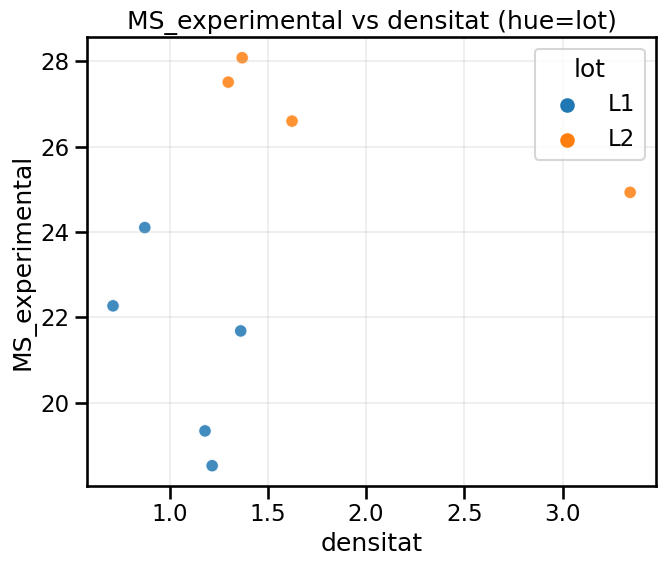

In [20]:
# MS_experimental vs densitat
fig, ax = plt.subplots(figsize=(7,6))
sns.scatterplot(data=df_final.reset_index(), x="densitat", y="MS_experimental", hue="lot", ax=ax, alpha=0.85)
ax.set_title("MS_experimental vs densitat (hue=lot)")
ax.grid(True, alpha=0.2)
fig.tight_layout()

out = FIG_DIR / "ms_vs_densitat.png"
fig.savefig(out, dpi=200, bbox_inches="tight")
print(f"✅ Figura guardada: {out}")
plt.show()


## Extra: Visualització del procès de neteja de la imatge

Mostra: 2
Imatge: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml\data\input\raw\raw_images\test_1\p1_2.png
Color mitjà (RGB) sobre FILTRAT, sense negres: [115.32337298  85.58691243  45.0583356 ]


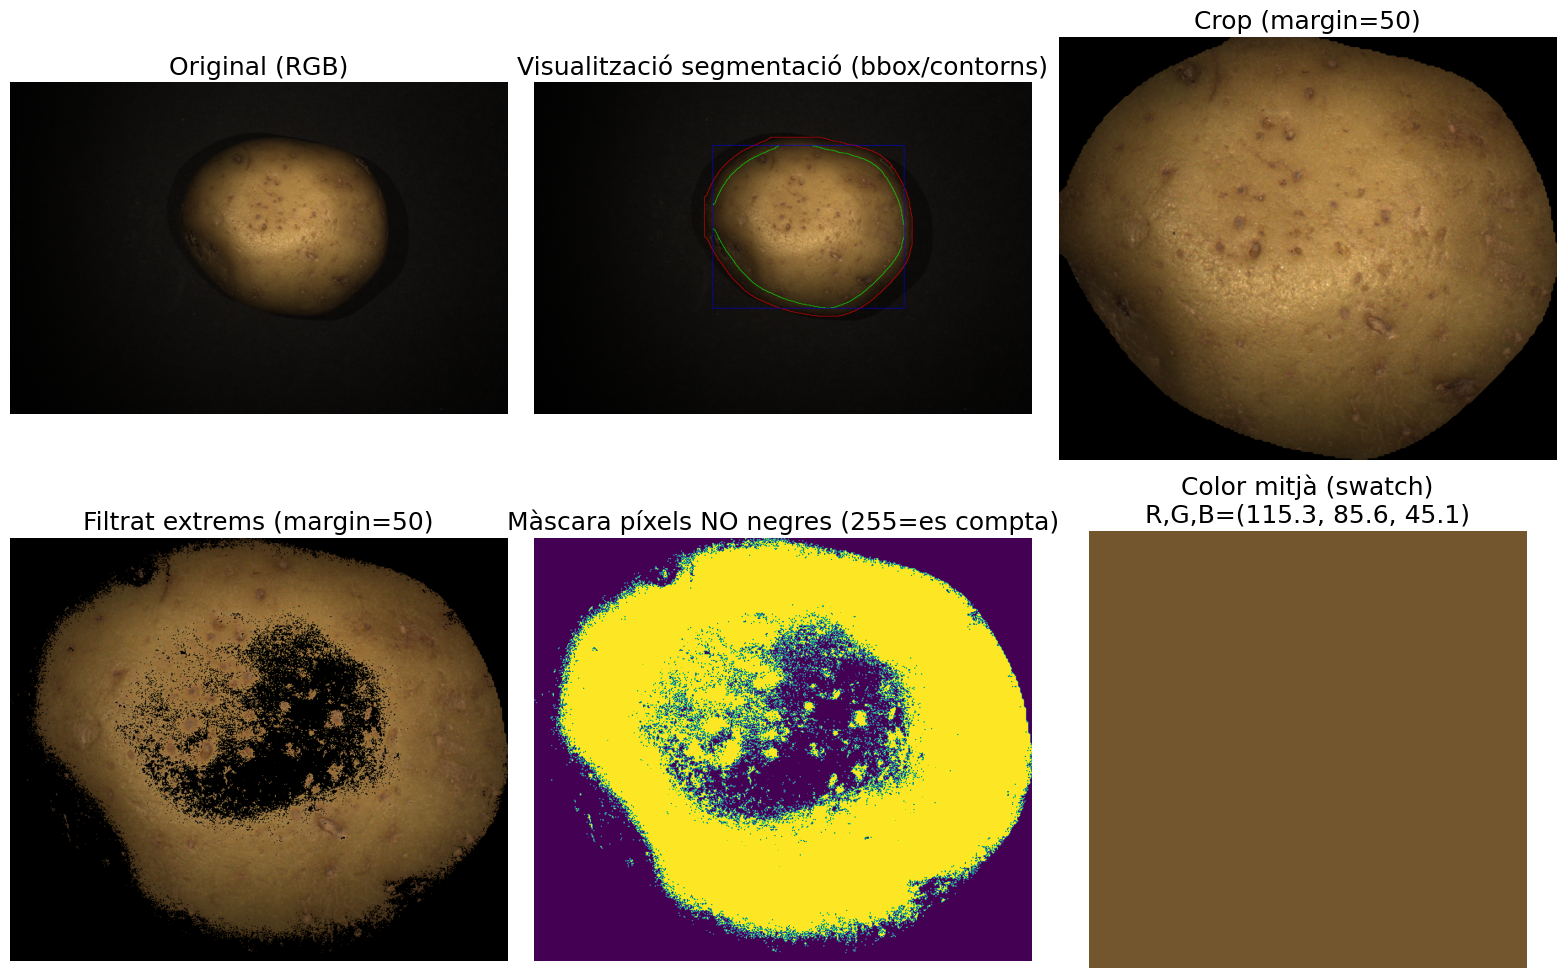

In [ ]:
# === DEBUG CELL (es pot borrar) ======================================
# Mostra el pipeline d'una patata: original -> crop -> filtrat + màscara
# i calcula/mostra el color mitjà (només píxels NO negres)

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Imports de funcions del projecte
try:
    from src.raw_image_treatment import potato_pixels_rgb_img, potato_filter_extreme_colours
except Exception as e:
    raise ImportError(
        "No he pogut importar des de src.raw_image_treatment.\n"
        "Assegura't que estàs executant aquest notebook dins del repo i que existeix src/raw_image_treatment.py\n"
        f"Error original: {e}"
    )

# --- Config -----------------------------------------------------------
SHOW_ID = None  # posa un int (id_mostra) si vols forçar-ne una, ex: 123
SEGMENT_MARGIN = 50
FILTER_MARGIN  = 50

def show_img(ax, img, title):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

def rgb_mean_ignore_black(pil_img):
    """Mitjana RGB ignorant píxels negres (0,0,0). Retorna (mean_rgb, mask_uint8_img)."""
    arr = np.asarray(pil_img, dtype=np.uint8)
    if arr.ndim != 3 or arr.shape[2] != 3:
        raise ValueError(f"Imatge RGB esperada, però arr shape={arr.shape}")

    mask = np.any(arr != 0, axis=2)  # True si el píxel NO és negre
    if mask.sum() == 0:
        return (np.array([np.nan, np.nan, np.nan]), None)

    vals = arr[mask]  # (N,3)
    mean = vals.mean(axis=0)  # float
    mask_img = (mask.astype(np.uint8) * 255)
    return mean, Image.fromarray(mask_img)

# --- Tria de mostra ---------------------------------------------------
df_src = df  # o df_final si ho prefereixes
if SHOW_ID is None:
    row = df_src.iloc[0]
    chosen_id = df_src.index[0]
else:
    chosen_id = int(SHOW_ID)
    row = df_src.loc[chosen_id]

ruta_col = "ruta_imatges" if "ruta_imatges" in df_src.columns else ("ruta_images" if "ruta_images" in df_src.columns else None)
if ruta_col is None:
    raise KeyError("No trobo la columna 'ruta_imatges' ni 'ruta_images' al dataframe.")

img_rel = str(row[ruta_col]).strip()
img_path = IMAGES_ROOT / img_rel

print(f"Mostra: {chosen_id}")
print(f"Imatge: {img_path}")

if not img_path.exists():
    raise FileNotFoundError(f"No existeix la imatge: {img_path}")

# --- 1) Original ------------------------------------------------------
orig = Image.open(img_path).convert("RGB")

# --- 2) Crop (segmentació) -------------------------------------------
cropped_img, vis = potato_pixels_rgb_img(img_path, margin=SEGMENT_MARGIN)

# --- 3) Filtrat de colors extrems ------------------------------------
filtered_img = None
if cropped_img is not None:
    filt_out = potato_filter_extreme_colours(cropped_img, margin=FILTER_MARGIN, ignore_black=True)
    filtered_img = filt_out[0] if isinstance(filt_out, tuple) else filt_out

# --- 4) Color mitjà sobre imatge filtrada (ignorant negres) ----------
mean_rgb = np.array([np.nan, np.nan, np.nan])
mask_img = None
mean_swatch = None

if filtered_img is not None:
    mean_rgb, mask_img = rgb_mean_ignore_black(filtered_img)
    # "swatch" (imatge d'un sol color) per visualitzar el color mitjà
    sw = np.ones((80, 80, 3), dtype=np.uint8)
    sw[:] = np.clip(np.round(mean_rgb), 0, 255).astype(np.uint8)
    mean_swatch = Image.fromarray(sw)

print(f"Color mitjà (RGB) sobre FILTRAT, sense negres: {mean_rgb}")

# --- Plot -------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

show_img(axes[0,0], orig, "Original (RGB)")

if vis is not None:
    show_img(axes[0,1], vis, "Visualització segmentació (bbox/contorns)")
else:
    axes[0,1].axis("off"); axes[0,1].set_title("Visualització segmentació: None")

if cropped_img is not None:
    show_img(axes[0,2], cropped_img, f"Crop (margin={SEGMENT_MARGIN})")
else:
    axes[0,2].axis("off"); axes[0,2].set_title("Crop: None")

if filtered_img is not None:
    show_img(axes[1,0], filtered_img, f"Filtrat extrems (margin={FILTER_MARGIN})")
else:
    axes[1,0].axis("off"); axes[1,0].set_title("Filtrat: None")

if mask_img is not None:
    show_img(axes[1,1], mask_img, "Màscara píxels NO negres (255=es compta)")
else:
    axes[1,1].axis("off"); axes[1,1].set_title("Màscara: None")

if mean_swatch is not None:
    show_img(axes[1,2], mean_swatch, f"Color mitjà (swatch)\nR,G,B={tuple(np.round(mean_rgb,1))}")
else:
    axes[1,2].axis("off"); axes[1,2].set_title("Color mitjà: None")

plt.tight_layout()
plt.show()
# =====================================================================
